In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import env

# plotting defaults
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

# Using saas.csv or log data from API usage or store_item_sales

- Split data (train/validate/test) and resample by any period, except daily, and aggregate using the sum.
- Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
    - Simple Average
    - Moving Average
    - Holt's Linear Trend Model
    - Based on previous year/month/etc., this is up to you.

## Acquire

In [2]:
df = pd.read_csv('saas.csv')

In [3]:
df.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [4]:
df.shape

(790458, 5)

In [5]:
df.Month_Invoiced = pd.to_datetime(df.Month_Invoiced)
df = df.set_index("Month_Invoiced").sort_index()
df['Month'] = df.index.month
df.head()

,Customer_Id,Invoice_Id,Subscription_Type,Amount,Month
Month_Invoiced,,,,,
2014-01-31,1000000,5000000,0.0,0.0,1
2014-01-31,1000001,5000001,2.0,10.0,1
2014-01-31,1000002,5000002,0.0,0.0,1
2014-01-31,1000003,5000003,0.0,0.0,1
2014-01-31,1000004,5000004,1.0,5.0,1


In [6]:
df.index.max(),df.index.min(), df.index.max() - df.index.min()

(Timestamp('2017-12-31 00:00:00'),
 Timestamp('2014-01-31 00:00:00'),
 Timedelta('1430 days 00:00:00'))

In [7]:
1430 / 4

357.5

In [8]:
df.isna().sum()

Customer_Id          0
Invoice_Id           0
Subscription_Type    0
Amount               0
Month                0
dtype: int64

In [9]:
df.index.year.value_counts()

2014    227542
2015    204352
2016    186275
2017    172289
Name: Month_Invoiced, dtype: int64

In [10]:
df.groupby(df.index.day).sum()

,Customer_Id,Invoice_Id,Subscription_Type,Amount,Month
Month_Invoiced,,,,,
28,52847449421,275631278579,27630.0,138150.0,104442
29,16230363306,87400384855,10391.0,51955.0,32038
30,264755078268,1414667784516,159187.0,795935.0,1945206
31,466831941481,2487002081703,276462.0,1382310.0,2982012


In [ ]:
# df = df[df.Subscription_Type != 0]
# df.head()

- I had initially removed '0' amounts, but later decided to keep them

In [11]:
len(df.index.value_counts())
# these are only end of month values 

48

In [ ]:
# train[:100]

In [12]:
df.columns

Index(['Customer_Id', 'Invoice_Id', 'Subscription_Type', 'Amount', 'Month'], dtype='object')

In [14]:
df = df.drop(columns = ['Customer_Id', 'Invoice_Id', 'Subscription_Type'])
df.head()

,Amount,Month
Month_Invoiced,,
2014-01-31,0.0,1
2014-01-31,10.0,1
2014-01-31,0.0,1
2014-01-31,0.0,1
2014-01-31,5.0,1


In [ ]:
# type(df.index)
# df = df.DataFrame(df)
# df = df.set_index("Month_Invoiced").sort_index()
# df['Month'] = df.index.month
# df.head()

In [15]:
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

## Making 2014 & 2015 train, 2016 validate, 2017 test:

In [16]:
train = df[:'2015']
validate = df['2016']
test = df['2017']
train.shape, validate.shape, test.shape

((431894, 2), (186275, 2), (172289, 2))

In [17]:
train[-1:], validate[:1], validate[-1:], test[:1]

(                Amount  Month
 Month_Invoiced               
 2015-12-31         0.0     12,
                 Amount  Month
 Month_Invoiced               
 2016-01-31         5.0      1,
                 Amount  Month
 Month_Invoiced               
 2016-12-31         0.0     12,
                 Amount  Month
 Month_Invoiced               
 2017-01-31         5.0      1)

- looking good for the splits

<AxesSubplot:xlabel='Month_Invoiced'>

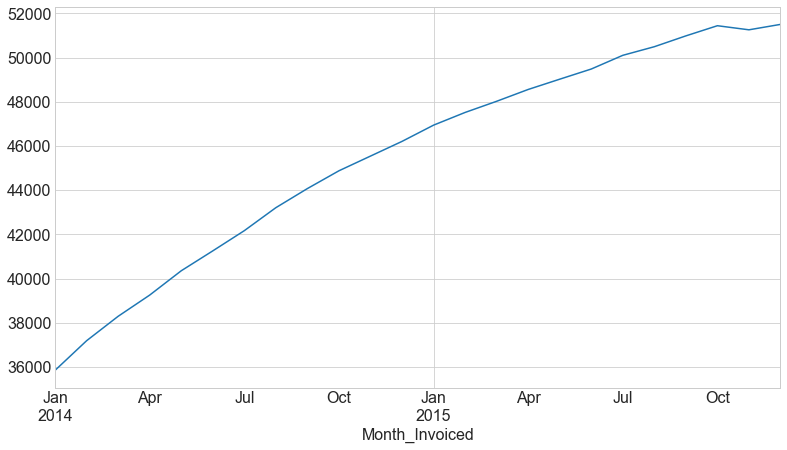

In [18]:
train.resample('M').Amount.sum().plot()

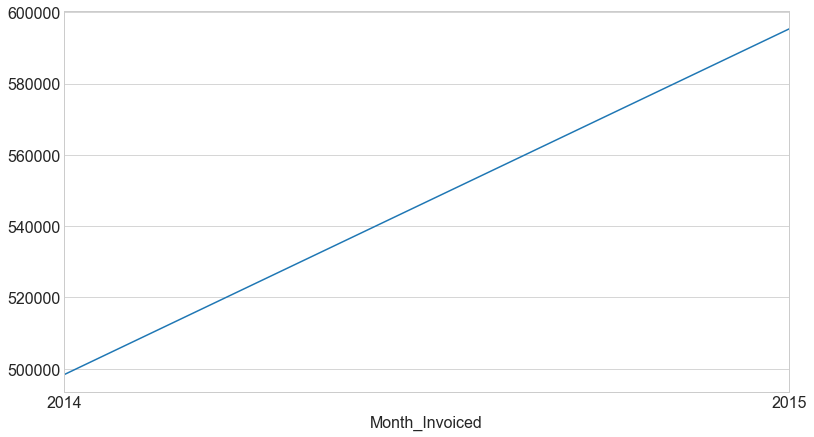

In [19]:
train.resample('Y').Amount.sum().plot();

<AxesSubplot:xlabel='Month_Invoiced'>

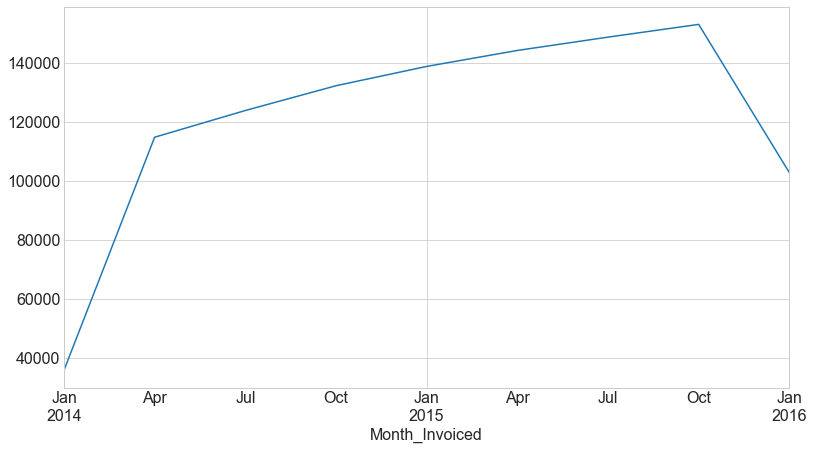

In [20]:
train.resample('3M').Amount.sum().plot()

<AxesSubplot:xlabel='Month_Invoiced'>

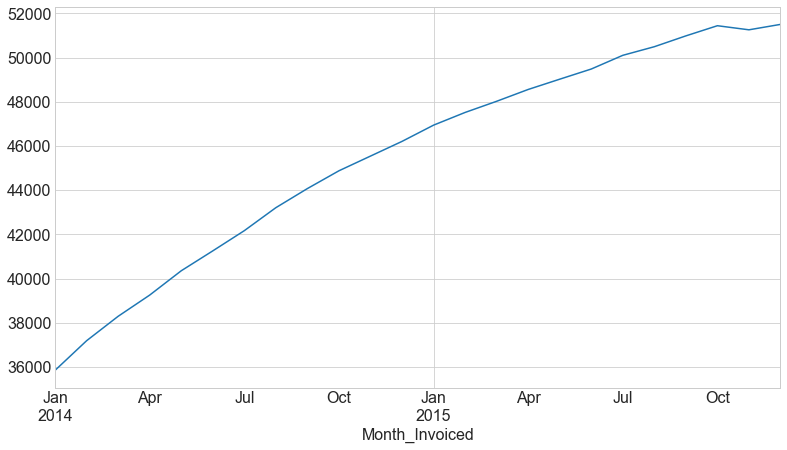

In [21]:
train.resample('M').Amount.sum().plot()

<AxesSubplot:xlabel='Month', ylabel='Amount'>

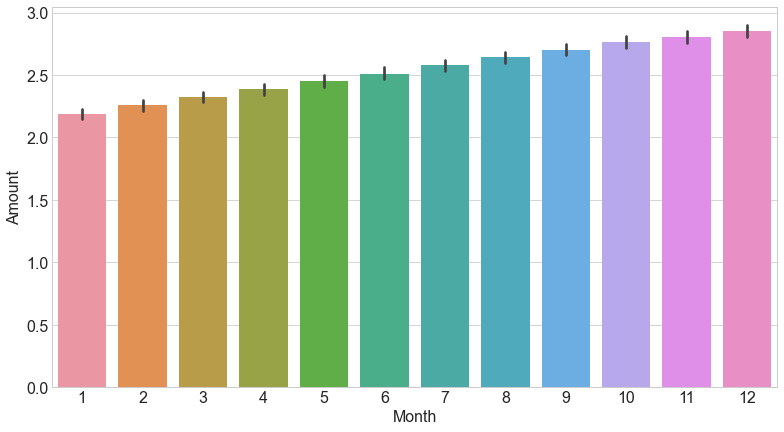

In [22]:
sns.barplot(data=train,x='Month',y='Amount')

[Text(0.5, 1.0, 'Quarterly % Change in Sales Total')]

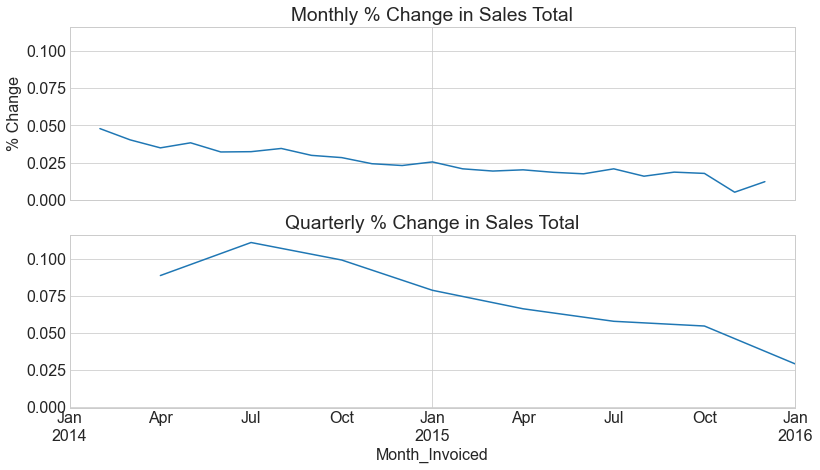

In [23]:
y = train.resample('M').Amount.mean()

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True)

Monthly = y.resample('M').mean()
(Monthly.diff() / Monthly.shift()).plot(ax=ax1)
ax1.set(title='Monthly % Change in Sales Total', ylabel='% Change', xlabel='')

Quarterly = y.resample('3M').mean()
(Quarterly.diff() / Quarterly.shift()).plot(ax=ax2)
ax2.set(title='Quarterly % Change in Sales Total')
# ax2.hlines(0, *ax2.get_xlim())

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

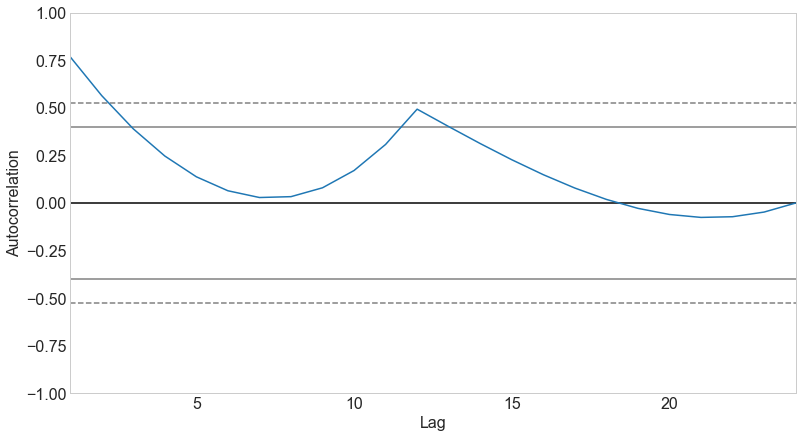

In [24]:
pd.plotting.autocorrelation_plot(train.resample('M').mean())

- this data is mostly noise, isn't it?

#### Decompose:

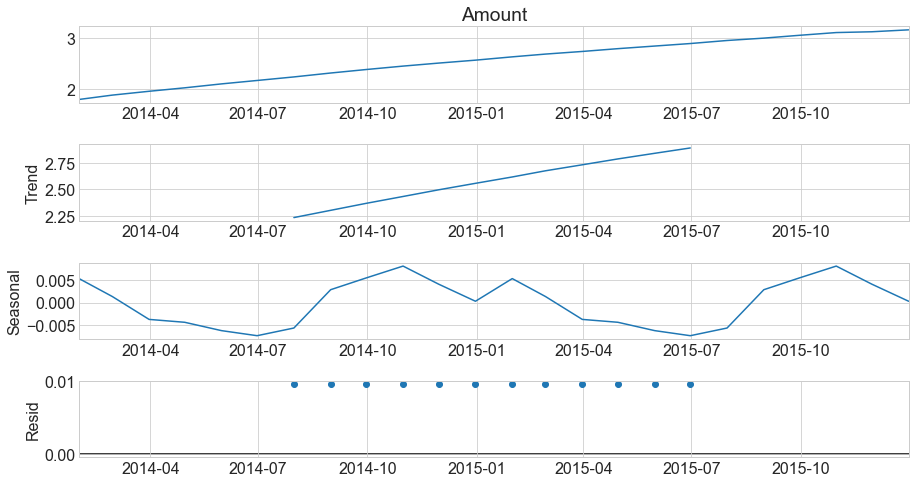

In [27]:
# decompose the data
sm.tsa.seasonal_decompose(y.resample('M').mean()).plot()
None